# Neural Nets for jet images

Notebook for training and evaluating neural network taggers using jet images.

This example is about separating jets (collimated sprays of hadronic particles) using an "imaging" technique based on a convolutional neural network. SignaL jets are from hadronic decays of W bosons, while background jets are produced from the hadronisation of light quarks, or gluons. The jets are measured in the detector calorimeter, where they leave their energy. The images are the trnasverse energies deposited by a jet in the calorimeter cells, with each image being centred on the jet axis, and the weight of each cell is the transverse energy deposited. Jets from background tend to have most of the transverse enrgy deposited in the centre, while those from BG, that are actually composed of two very nearby jets, present rather a two-prong structure, and the network should be able to distinguish the two cases.
Write a concolutional neural network to distinguish the teo classes, train it, and evaluate its performance.


---

---

# **Jets Project - Initial Sequential Data Optimisation Notebook** 
*Student Number: 20006434* 

***Project Description:***
As explained in the project brief above, this project concerns the classification of jet images through use of a convolutional neural network. A model will be created, optimised and evaluated; with all results, decisions and conclusions written up in the report.

***This Notebook:***
This notebook corresponds to the initial, rough investigations using the images of all 4 datasets individually for training. For the finalised model and results, refer to the **Merged Data notebook**, which has a cleaner structure.

## Notebook Setup
We will start by setting up the notebook for coding, by importing libraries and connecting the notebook to our google drive, such that files can be loaded and downloaded.

In [1]:
# Importing the necessary libraries
from __future__ import division, print_function
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.regularizers import l1_l2
from keras.callbacks import EarlyStopping
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from datetime import datetime
import os, sys
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.python.client import device_lib

### Neural Network Configuration
We will now define useful parameters, which will be referred to later for model compilation and training.

In [2]:
# Defining loss functions/optimizers, number of epochs and the training/validation split
loss_function = 'categorical_crossentropy' #'mean_squared_logarithmic_error' #'mean_squared_error' 
optimizer = 'adam'
nb_epochs = 10
test_sample_size = 0.25

# Defining the number of images to select from the datsets (full number of lund planes)
nb_top_lund_planes = 10000
nb_QCD_lund_planes = 10000
nb_W_lund_planes = 10000


# Defining the paths to the necessary jet image datasets
inputs = ["/content/drive/MyDrive/Colab Notebooks/Project/20190920_partial_10k/20190920_pt300.0_600.0_40bins_10k.npz", 
          "/content/drive/MyDrive/Colab Notebooks/Project/20190920_partial_10k/20190920_pt600.0_1500.0_40bins_10k.npz", 
          "/content/drive/MyDrive/Colab Notebooks/Project/20190920_partial_10k/20190920_pt1500.0_2500.0_40bins_10k.npz",
          "/content/drive/MyDrive/Colab Notebooks/Project/20190920_partial_10k/20190920_pt2500.0_5000.0_40bins_10k.npz"]

In [3]:
# Loading my drive to google colab, for the uploading/downloading of files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Loading Data
We will now define a function to import, manipulate and output the images from a dataset. We will then check that the images have been imported, by loading a random image from both signal and background categories, as well as the overall sum of both, to see any overarching patterns.

In [4]:
# Defining the function to load the images
def import_data(filename, n):
  '''This function takes input of a single filename and signal-selecting string,
  and returns the training and validation image sets and labels, along with arrays 
  of the pure, imported images'''
  
  # Load the data
  input_data = np.load(filename)

  # Seperate off the images
  top_samples=input_data['top_jet_images'][:nb_top_lund_planes]    #signal
  w_samples=input_data['W_jet_images'][:nb_W_lund_planes]          #signal
  qcd_samples=input_data['QCD_jet_images'][:nb_QCD_lund_planes]    #background gluon and quark

  # Identifying which signal to use
  if n=='top':
    X_S = top_samples   # Use signals from top quark jets
  elif n=='w':
    X_S = w_samples     # Use signals from w boson decay jets
  else:
    raise Exception("Please pick either 'top' or 'w' samples")
  
  # Identify the background jets and shuffle, as background should be unrelated to signal order/images
  X_BG = qcd_samples 
  np.random.shuffle(X_BG)

  # Create labels
  y_S = np.ones(len(X_S))
  y_BG = np.zeros(len(X_BG)) 

  # Make image and label arrays
  X = np.append(X_S, X_BG, axis=0)
  y = np.append(y_S, y_BG, axis=0)

  # CNN architecture is built to take color images. 
  # Therefore, reshape input to: 1 colour channel + 1 image channel
  X = X.reshape( (X.shape[0], X.shape[1], X.shape[2], 1) )

  # Split data into training and testing
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_sample_size)

  # Reshape target vectors
  y = to_categorical(y, 2)
  y_train = to_categorical(y_train, 2)
  y_test = to_categorical(y_test, 2)
  
  # Taking 1 label from the [1 SG,0 BG] target pairs, as avoiding 1-hot vector system
  y_train_single = np.reshape([x[0] for x in y_train],(15000,1))   #15000 per
  y_test_single = np.reshape([x[0] for x in y_test],(5000,1))     #5000 per

  return X_train, X_test, y_train_single, y_test_single, X_S, X_BG

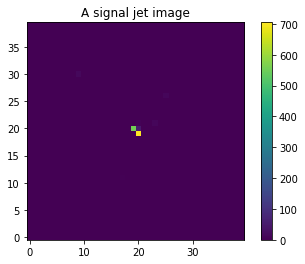

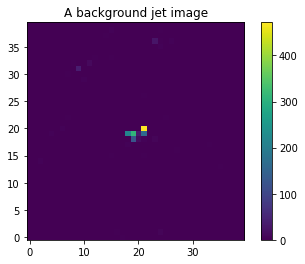

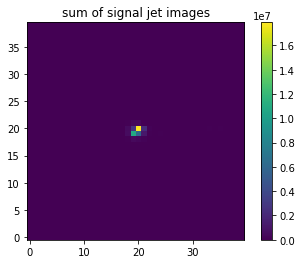

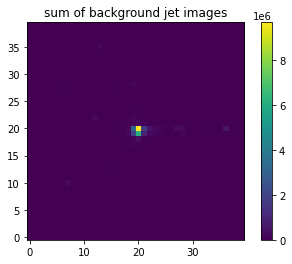

In [ ]:
# Running the function to load the data 
X_train, X_test, y_train_single, y_test_single, X_S, X_BG = import_data(inputs[2], 'w')

# Picking a random image index to display
iimg_sig = np.random.randint(0,len(X_S))
iimg_bkg = np.random.randint(0,len(X_BG))

# Plotting a random signal jet image
plt.figure()
plt.title("A signal jet image")
plt.imshow(X_S[iimg_sig].reshape(X_S.shape[1], X_S.shape[2]), origin="lower")
plt.colorbar()
plt.savefig('RandSig.png',dpi=300, facecolor='w');

# Plotting a random background jet image
plt.figure()
plt.title("A background jet image")
plt.imshow(X_BG[iimg_bkg].reshape(X_BG.shape[1], X_BG.shape[2]), origin="lower")
plt.colorbar()
plt.savefig('RandBG.png',dpi=300, facecolor='w');

# Plotting the sum of all signal jet images
plt.figure()
plt.title("sum of signal jet images")
plt.imshow(np.sum(X_S, axis=0).reshape(X_S.shape[1], X_S.shape[2]), origin="lower")
plt.colorbar();

# Plotting the sum of all background jet images
plt.figure()
plt.title("sum of background jet images")
plt.imshow(np.sum(X_BG, axis=0).reshape(X_BG.shape[1], X_BG.shape[2]), origin="lower")
plt.colorbar();

# Training
We will now create and train a model, and investigate the effect of changing different model parameters. We will initially investigate the effect of changing:
- The number of filters in the convolutional layer
- The dropout layer rate value
- The number of convolutional layers
- The number of dense layers

### Investigating the effect of filter number for convolutional layers

In [ ]:
# Defining filter values to test
number=np.arange(20,500,20)
acc=[]
vacc=[]

# Looping over all filter values
for i in number:

  # Defining the model
  model = keras.models.Sequential()
  model.add(keras.layers.Conv2D(i, (3, 3), activation='relu', input_shape=(40, 40, 1)))
  model.add(keras.layers.MaxPooling2D((2, 2)))
  model.add(keras.layers.Dropout(rate=.3))

  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(500, activation='relu'))
  model.add(keras.layers.Dense(2, activation='sigmoid'))

  # Compiling and training the model
  model.compile(optimizer=optimizer,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
  history = model.fit(X_train, y_train_single, epochs=4, validation_data=(X_test, y_test_single))

  # Appending history values for plotting
  acc.append(history.history['accuracy'][-1])
  vacc.append(history.history['val_accuracy'][-1])

# Saving history data
np.savetxt("Convlayercheck-number-acc-vacc.csv", np.column_stack((number,acc, vacc)), delimiter=",")

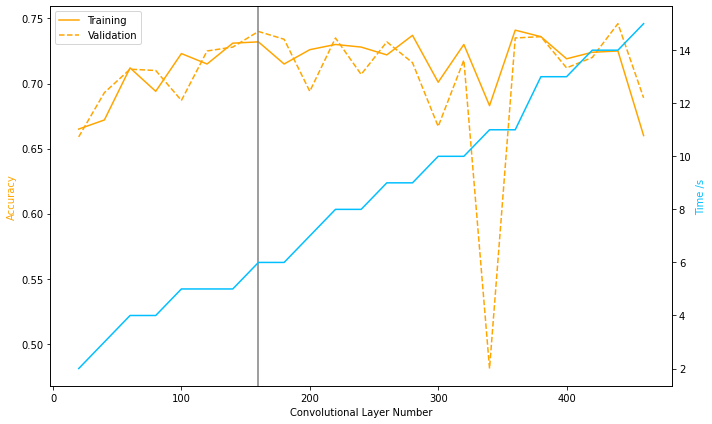

In [ ]:
# Loading history data
filename = "/content/drive/MyDrive/Colab Notebooks/Project/Convlayercheck-number-acc-vacc (1).csv"
df=pd.read_csv(filename,header=None)

# Defining a figure
fig, ax1 = plt.subplots(figsize=(10,6))

# Plotting the effects on the accuracy metrics
ax1.set_xlabel('Convolutional Layer Number',)
ax1.set_ylabel('Accuracy', color='orange')
ax1.plot(df[0], df[1], label='Training', color='orange')
ax1.plot(df[0], df[2], label='Validation', color='orange',linestyle='--')

# Plotting the effects on time
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Time /s', color='deepskyblue')
ax2.plot(df[0], df[3], color='deepskyblue')

# Formatting and saving the figure
ax1.legend()
ax1.axvline(x=160,color='grey')
fig.tight_layout()
fig.savefig('ConvFilterNumber.png',dpi=300, facecolor='w');

### Investigating the effect of dropout layer rate value

In [ ]:
# Defining rate values to test
rates=np.arange(0.1,1,0.1)
acc=[]
vacc=[]

# Looping over all rate values
for i in rates:

  # Defining the model
  model = keras.models.Sequential()
  model.add(keras.layers.Conv2D(160, (3, 3), activation='relu', input_shape=(40, 40, 1)))
  model.add(keras.layers.MaxPooling2D((2, 2)))
  model.add(keras.layers.Dropout(rate=i))

  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(500, activation='relu'))
  model.add(keras.layers.Dense(2, activation='sigmoid'))

  # Compiling and training the model
  model.compile(optimizer=optimizer,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
  history = model.fit(X_train, y_train_single, epochs=4, validation_data=(X_test, y_test_single))

  # Appending history values for plotting
  acc.append(history.history['accuracy'][-1])
  vacc.append(history.history['val_accuracy'][-1])

# Saving history data
#np.savetxt("Rate check-rate-acc-vacc.csv", np.column_stack((rates,acc,vacc)), delimiter=",")

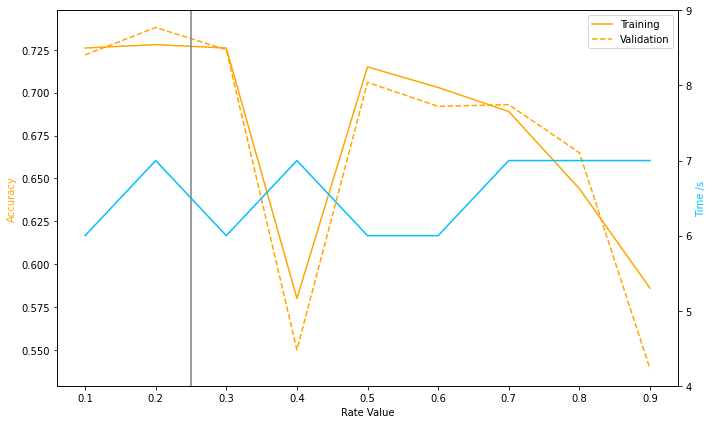

In [ ]:
# Loading history data
filename = "/content/drive/MyDrive/Colab Notebooks/Project/Rate check-rate-acc-vacc.csv"
df=pd.read_csv(filename,header=None)

# Defining a figure
fig, ax1 = plt.subplots(figsize=(10,6))

# Plotting the effects on the accuracy metrics
ax1.set_xlabel('Rate Value')
ax1.set_ylabel('Accuracy', color='orange')
ax1.plot(df[0], df[1], label='Training', color='orange')
ax1.plot(df[0], df[2], label='Validation', color='orange',linestyle='--')

# Plotting the effects on time
ax2 = ax1.twinx()                # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Time /s', color='deepskyblue')
ax2.plot(df[0], df[3], color='deepskyblue')
ax2.set_ylim(4,9)                # Setting limits for clearer scaling

# Formatting and saving the figure
ax1.legend()
ax1.axvline(x=0.25,color='grey')
fig.tight_layout()
fig.savefig('Rate Value.png',dpi=300, facecolor='w');

### Investigating the effect of the number of convolutional layers

In [ ]:
# Defining the model
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(40, 40, 1)))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))   #Testing
model.add(keras.layers.MaxPooling2D((2, 2)))                    #Testing
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))   #Testing
model.add(keras.layers.MaxPooling2D((2, 2)))                    #Testing
model.add(keras.layers.Dropout(rate=.25))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dense(2, activation='sigmoid'))

# Compiling and training the model
model.compile(optimizer=optimizer,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history = model.fit(X_train, y_train_single, epochs=4, validation_data=(X_test, y_test_single))

Epoch 1/4
469/469 [==============================] - 67s 140ms/step - loss: 1.2855 - accuracy: 0.5320 - val_loss: 0.6951 - val_accuracy: 0.5584
Epoch 2/4
469/469 [==============================] - 69s 148ms/step - loss: 0.7812 - accuracy: 0.5427 - val_loss: 0.7114 - val_accuracy: 0.5234
Epoch 3/4
469/469 [==============================] - 63s 134ms/step - loss: 0.7732 - accuracy: 0.5267 - val_loss: 0.7119 - val_accuracy: 0.5298
Epoch 4/4
469/469 [==============================] - 66s 142ms/step - loss: 0.7435 - accuracy: 0.5208 - val_loss: 0.6881 - val_accuracy: 0.5134


### Investigating the effect of the number of dense layers

In [ ]:
# Defining the model
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(40, 40, 1)))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(16, (3, 3), activation='relu'))
model.add(keras.layers.Dropout(rate=.25))                         

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dense(2, activation='sigmoid'))

# Compiling and training the model
model.compile(optimizer=optimizer,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history = model.fit(X_train, y_train_single, epochs=4, validation_data=(X_test, y_test_single))

Epoch 1/4


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


469/469 [==============================] - 25s 45ms/step - loss: 1.8860 - accuracy: 0.5763 - val_loss: 0.8475 - val_accuracy: 0.6102
Epoch 2/4
469/469 [==============================] - 20s 43ms/step - loss: 0.8943 - accuracy: 0.6111 - val_loss: 0.8159 - val_accuracy: 0.6300
Epoch 3/4
469/469 [==============================] - 20s 42ms/step - loss: 0.9451 - accuracy: 0.6337 - val_loss: 0.8042 - val_accuracy: 0.6258
Epoch 4/4
469/469 [==============================] - 19s 41ms/step - loss: 0.8327 - accuracy: 0.6620 - val_loss: 0.6558 - val_accuracy: 0.6878


# Final Model

In [ ]:
# Defining the model
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(160, (3, 3), activation='relu', input_shape=(40, 40, 1)))
model.add(keras.layers.Conv2D(160, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(rate=.3))                         
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(400, activation='relu'))    #kernel_regularizer=l1_l2()))  # defaults 0.01 both
model.add(keras.layers.Dropout(rate=.3))
model.add(keras.layers.Dense(200, activation='relu'))
model.add(keras.layers.Dense(2, activation='sigmoid'))

# Printing a summary and compiling the model
model.summary()
model.compile(optimizer=optimizer,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Investigating the effect of Early Stopping
#es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 38, 38, 160)       1600      
                                                                 
 conv2d_5 (Conv2D)           (None, 36, 36, 160)       230560    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 18, 18, 160)      0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 18, 18, 160)       0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 9, 9, 160)        0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 12960)            

In [ ]:
# Defining empty lists for appending metric values
acc=[]
vacc=[]
loss=[]
vloss=[]

# Defining useful training information
nb_epochs=15
batch_size=64

# Looping over each .npz file
for i in inputs:

  # Loading Data
  X_train, X_test, y_train_single, y_test_single, X_S, X_BG = import_data(i, 'w')

  # Training model
  history = model.fit(X_train, y_train_single, epochs=nb_epochs, batch_size=batch_size, validation_data=(X_test, y_test_single)) #callbacks=[es])

  # Appending history information
  acc.append(history.history['accuracy'])
  vacc.append(history.history['val_accuracy'])
  loss.append(history.history['loss'])
  vloss.append(history.history['val_loss'])

# Flattening to single lists for plotting
flat_acc = [item for sublist in acc for item in sublist]
flat_vacc = [item for sublist in vacc for item in sublist]
flat_loss = [item for sublist in loss for item in sublist]
flat_vloss = [item for sublist in vloss for item in sublist]
epoch_list=np.reshape(np.arange(1,nb_epochs*4+1,1)  , (4,nb_epochs))
flat_epoch = [item for sublist in epoch_list for item in sublist]

#np.savetxt(f"Model Training{batch_size}15epochs 20 dense.csv", np.column_stack((flat_acc, flat_vacc, flat_loss, flat_vloss)), delimiter=",")

Epoch 1/15
235/235 [==============================] - 9s 34ms/step - loss: 0.9520 - accuracy: 0.6906 - val_loss: 0.6131 - val_accuracy: 0.7308
Epoch 2/15
235/235 [==============================] - 7s 32ms/step - loss: 0.7165 - accuracy: 0.7158 - val_loss: 0.5721 - val_accuracy: 0.7348
Epoch 3/15
235/235 [==============================] - 8s 33ms/step - loss: 0.8038 - accuracy: 0.7161 - val_loss: 0.5688 - val_accuracy: 0.7394
Epoch 4/15
235/235 [==============================] - 8s 32ms/step - loss: 0.6048 - accuracy: 0.7250 - val_loss: 0.5529 - val_accuracy: 0.7480
Epoch 5/15
235/235 [==============================] - 8s 32ms/step - loss: 0.6432 - accuracy: 0.7227 - val_loss: 0.5291 - val_accuracy: 0.7466
Epoch 6/15
235/235 [==============================] - 8s 32ms/step - loss: 0.6254 - accuracy: 0.7351 - val_loss: 0.5546 - val_accuracy: 0.7316
Epoch 7/15
235/235 [==============================] - 7s 32ms/step - loss: 0.6622 - accuracy: 0.7337 - val_loss: 0.5829 - val_accuracy: 0.7390

In [6]:
# Unused code for saving and loading models
  #model.save('my_model.h5')
  #model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Project/model data/my_model.h5')

### History Plotting

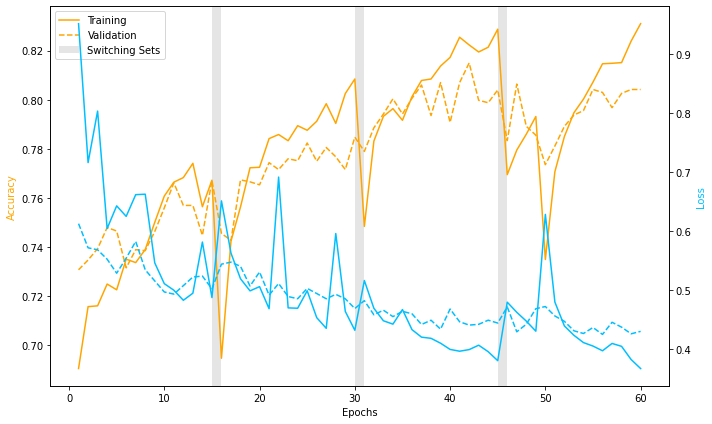

In [ ]:
# Creating x-axis epoch data
x=np.arange(1,61,1)

# Loading the history data
filename = "/content/Model Training 64 extrapool 15ep.csv"
df=pd.read_csv(filename,header=None)

# Defining a figure
fig, ax1 = plt.subplots(figsize=(10,6))

# Plotting the two accuracy metric progressions
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color='orange')
ax1.plot(x, df[0], label='Training', color='orange')
ax1.plot(x, df[1], label='Validation', color='orange',linestyle='--')

# Plotting the two loss metric progressions
ax2 = ax1.twinx()                   # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Loss', color='deepskyblue')
ax2.plot(x, df[2], label='Training', color='deepskyblue')
ax2.plot(x, df[3], label='Validation', color='deepskyblue',linestyle='--')

# Adding shaded areas to represent when the different image sets are used
ax1.axvspan(nb_epochs, nb_epochs+1, color='grey', alpha=0.2, lw=0, label='Switching Sets')
ax1.axvspan(nb_epochs*2, nb_epochs*2+1, color='grey', alpha=0.2, lw=0)
ax1.axvspan(nb_epochs*3, nb_epochs*3+1, color='grey', alpha=0.2, lw=0)

# Formatting the figure
ax1.legend()
fig.tight_layout()
plt.savefig('Graph 64 extrapool 15ep.csv.png',dpi=300, facecolor='w')

# Evaluation
We will consider the Accuracy, F1-score and ROC AUC metrics to evaluate how well the model can classify the two jet types.

In [7]:
# Evaluating the accuracy on each image set
for i in inputs:

  # Loading the images and evaluating their accuracy
  X_train, X_test, y_train_single, y_test_single, X_S, X_BG = import_data(i, 'w')
  results=model.evaluate(X_test,y_test_single,batch_size=64)

/usr/local/lib/python3.9/dist-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


79/79 [==============================] - 1s 9ms/step - loss: 0.3611 - accuracy: 0.8402


# Conclusion

Despite having a model which appears to train to high validation accuracy, the performance varies enormously on the image set used when validated. This prompts a consideration into using a merged set of images, such that the model can train to be more general. This should then improve the model's performance when evaluated on each image set individually.

**SEE MERGED DATA NOTEBOOK**